# In this project, we are going to predict the survival of the passengers on the Titanic ship. Here we have the data of around 891 passengers in training set and 418 in our test set. 

In [2]:
# Import Dependencies
%matplotlib inline

# Start Python Imports
import math, time, random, datetime

# Data Manipulation
import numpy as np
import pandas as pd

# Visualization 
import matplotlib.pyplot as plt
import missingno
import seaborn as sns
plt.style.use('seaborn-whitegrid')

# Preprocessing
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, label_binarize

# Machine learning
import catboost
from sklearn.model_selection import train_test_split
from sklearn import model_selection, tree, preprocessing, metrics, linear_model
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier, Pool, cv

# Let's be rebels and ignore warnings for now
import warnings
warnings.filterwarnings('ignore')



In [3]:
#importing train and test data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample = pd.read_csv('gender_submission.csv')

In [4]:
#this is our training set
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
#number of rows in training set
len(train)

891

In [6]:
#this is our test set
test.head() #head shows top 5 data

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [7]:
#number of rows in test set
len(test)

418

In [8]:
train.describe() #this shoes that we have some missing data in age coulmn.

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


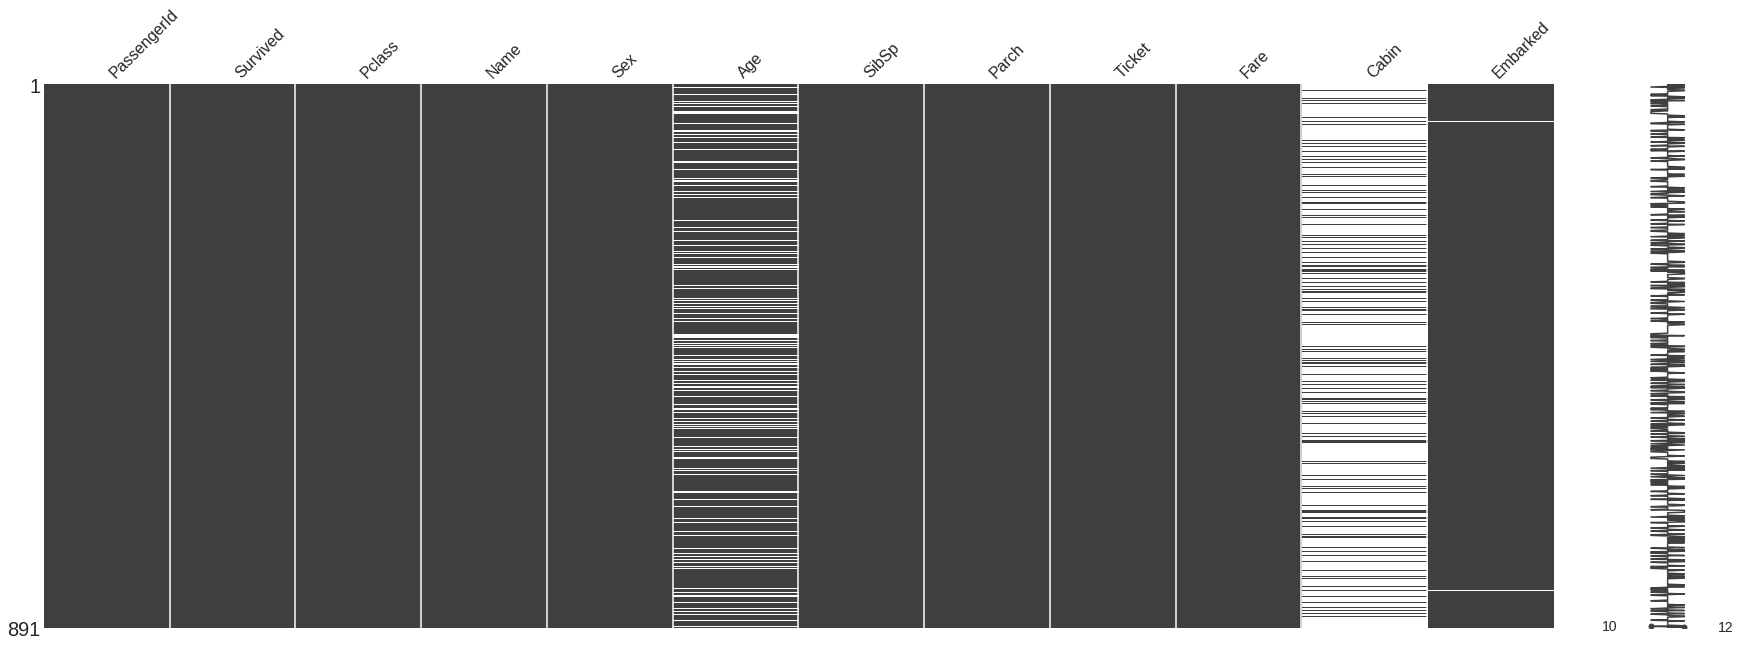

In [9]:
missingno.matrix(train, figsize = (30, 10))

In [10]:
#columns are
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [11]:
#find the number of missing values in each column
#we can call it our missing data dictionary

def find_missing_values(df, columns):
    missing_values = {}
    print("number of missing and NaN values for each columns")
    df_length = len(df)
    for column in columns:
        total_column_values = df[column].value_counts().sum()
        missing_values[column] = df_length-total_column_values
    return missing_values
missing_values = find_missing_values(train, columns = train.columns)

#printing dictionary
missing_values

number of missing and NaN values for each columns


{'PassengerId': 0,
 'Survived': 0,
 'Pclass': 0,
 'Name': 0,
 'Sex': 0,
 'Age': 177,
 'SibSp': 0,
 'Parch': 0,
 'Ticket': 0,
 'Fare': 0,
 'Cabin': 687,
 'Embarked': 2}

In [12]:
#before we start analysing, let's create two dataframes

df_bin = pd.DataFrame() #for discretized continuous variables
df_con = pd.DataFrame() #for continuous variables

In [13]:
#now let's check the datatypes in our data sets
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

# now we'll see each column one by one

# SURVIVED

0    549
1    342
Name: Survived, dtype: int64


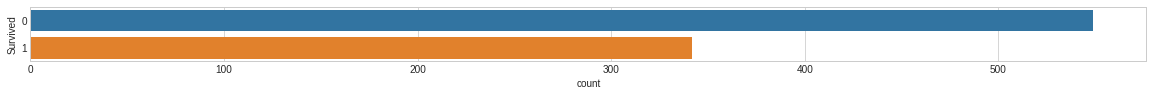

In [14]:
#here we are looking for the number of people survived in the training set

fig = plt.figure(figsize = (20,1))
sns.countplot(y = 'Survived', data = train)
print(train.Survived.value_counts())

In [15]:
#putting the values in both the dataframes

df_bin['Survived'] = train['Survived']
df_con['Survived'] = train['Survived']

In [16]:
df_bin.head()

,Survived
0,0
1,1
2,1
3,1
4,0


In [17]:
df_con.head()

,Survived
0,0
1,1
2,1
3,1
4,0


# **Pclass**

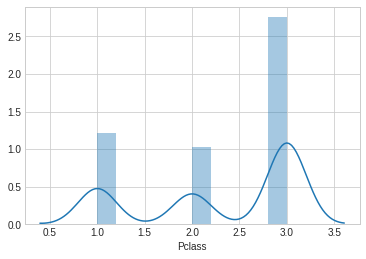

In [18]:
sns.distplot(train.Pclass)

In [19]:
missing_values['Pclass'] #missing value in pclass

0

In [20]:
#let's put it in our dataframes

df_bin['Pclass'] = train['Pclass']
df_con['Pclass'] = train['Pclass']

In [21]:
df_bin.head()

,Survived,Pclass
0,0,3
1,1,1
2,1,3
3,1,1
4,0,3


In [22]:
df_con.head()

,Survived,Pclass
0,0,3
1,1,1
2,1,3
3,1,1
4,0,3


# Names 

In [23]:
#different names in training set

train.Name.value_counts()

Baxter, Mr. Quigg Edmond                                    1
Holverson, Mr. Alexander Oskar                              1
Richards, Mrs. Sidney (Emily Hocking)                       1
Vande Walle, Mr. Nestor Cyriel                              1
Jensen, Mr. Hans Peder                                      1
Reuchlin, Jonkheer. John George                             1
Saad, Mr. Khalil                                            1
Davis, Miss. Mary                                           1
Spedden, Mrs. Frederic Oakley (Margaretta Corning Stone)    1
Chaffee, Mr. Herbert Fuller                                 1
Yousif, Mr. Wazli                                           1
Coleff, Mr. Satio                                           1
Lefebre, Miss. Jeannie                                      1
Lennon, Mr. Denis                                           1
Sedgwick, Mr. Charles Frederick Waddington                  1
Greenfield, Mr. William Bertram                             1
Hood, Mr

# Sex 

male      577
female    314
Name: Sex, dtype: int64


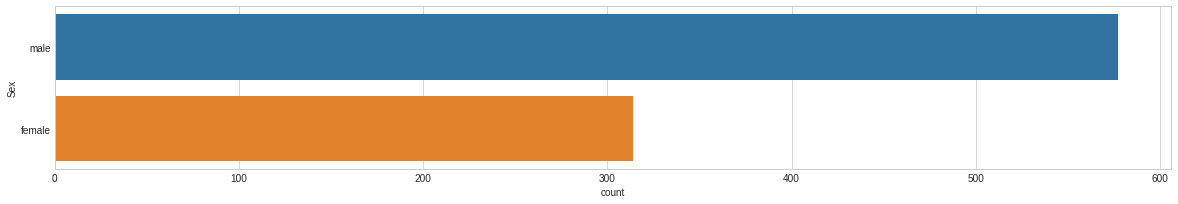

In [24]:
#here we calculate the number of males and females in our training set

plt.figure(figsize = (20,3))
sns.countplot(y = 'Sex', data = train)
print(train.Sex.value_counts())

In [25]:


# add Sex to the subset dataframes
df_bin['Sex'] = train['Sex']
df_bin['Sex'] = np.where(df_bin['Sex'] == 'female', 1, 0) # change sex to 0 for male and 1 for female

df_con['Sex'] = train['Sex']



In [26]:
df_bin.Sex.value_counts()

0    577
1    314
Name: Sex, dtype: int64

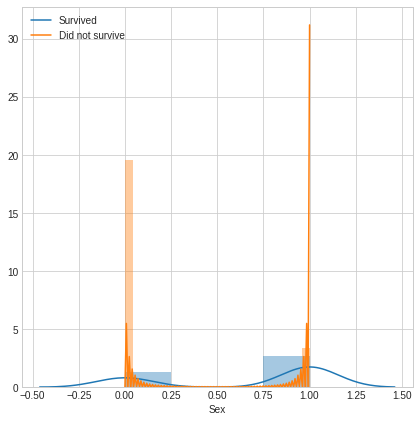

In [27]:
# How does the Sex variable look compared to Survival?
# We can see this because they're both binarys.
fig = plt.figure(figsize=(7, 7))
sns.distplot(df_bin.loc[df_bin['Survived'] == 1]['Sex'], kde_kws={'label': 'Survived'});
sns.distplot(df_bin.loc[df_bin['Survived'] == 0]['Sex'], kde_kws={'label': 'Did not survive'});

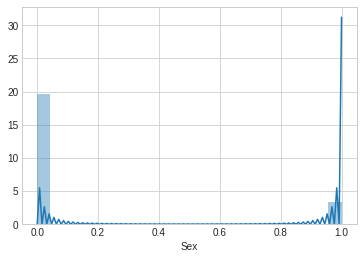

In [28]:
sns.distplot(df_bin.loc[df_bin['Survived'] == 0]['Sex'], label='sae_ae = 1')

# Age 

In [29]:
missing_values['Age'] #missing values in age

177

In [30]:
#df_bin['Age'] = pd.cut(train['Age'], 10) #binned into different catagories
#df_con['Age'] = train['Age']

In [31]:


def plot_count_dist(data, bin_df, label_column, target_column, figsize=(20, 5), use_bin_df=False):
    """
    Function to plot counts and distributions of a label variable and 
    target variable side by side.
    ::param_data:: = target dataframe
    ::param_bin_df:: = binned dataframe for countplot
    ::param_label_column:: = binary labelled column
    ::param_target_column:: = column you want to view counts and distributions
    ::param_figsize:: = size of figure (width, height)
    ::param_use_bin_df:: = whether or not to use the bin_df, default False
    """
    if use_bin_df: 
        fig = plt.figure(figsize=figsize)
        plt.subplot(1, 2, 1)
        sns.countplot(y=target_column, data=bin_df);
        plt.subplot(1, 2, 2)
        sns.distplot(data.loc[data[label_column] == 1][target_column], 
                     kde_kws={"label": "Survived"});
        sns.distplot(data.loc[data[label_column] == 0][target_column], 
                     kde_kws={"label": "Did not survive"});
    else:
        fig = plt.figure(figsize=figsize)
        plt.subplot(1, 2, 1)
        sns.countplot(y=target_column, data=data);
        plt.subplot(1, 2, 2)
        sns.distplot(data.loc[data[label_column] == 1][target_column], 
                     kde_kws={"label": "Survived"});
        sns.distplot(data.loc[data[label_column] == 0][target_column], 
                     kde_kws={"label": "Did not survive"});



# SibSp

In [32]:
missing_values['SibSp']

0

In [33]:
train.SibSp.value_counts()

0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64

In [34]:
df_bin['SibSp'] = train['SibSp']
df_con['SibSp'] = train['SibSp']

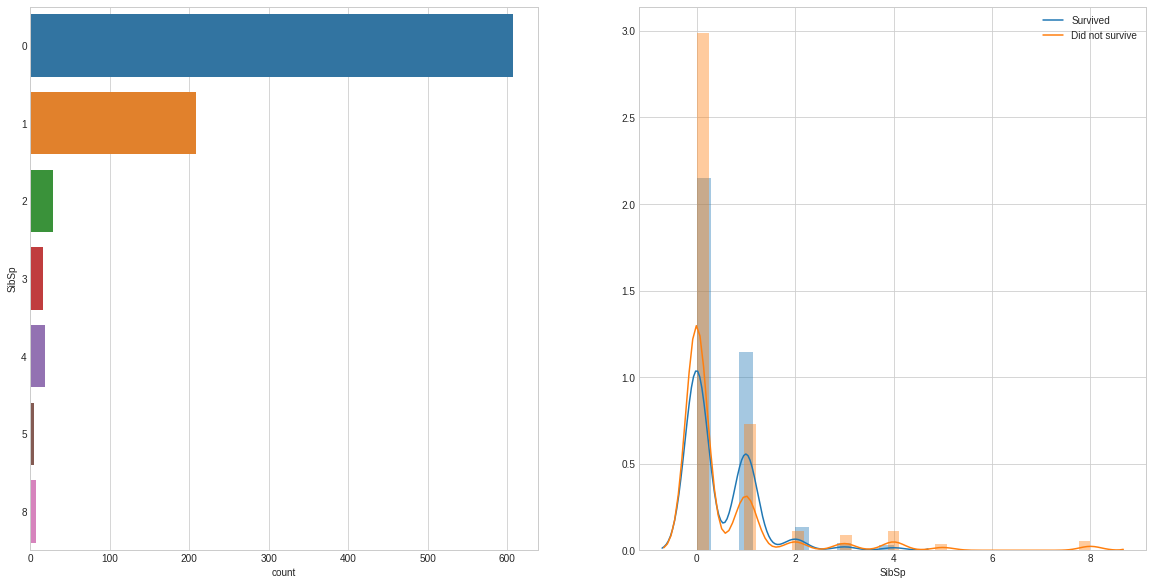

In [35]:
# Visualise the counts of SibSp and the distribution of the values
# against Survived
plot_count_dist(train, 
                bin_df=df_bin, 
                label_column='Survived', 
                target_column='SibSp', 
                figsize=(20, 10))

In [36]:
df_bin.head()

,Survived,Pclass,Sex,SibSp
0,0,3,0,1
1,1,1,1,1
2,1,3,1,0
3,1,1,1,1
4,0,3,0,0


# Parch 

In [37]:
missing_values['Parch']

0

In [38]:
train.Parch.value_counts()

0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64

In [39]:
df_bin['Parch'] = train['Parch']
df_con['Parch'] = train['Parch']

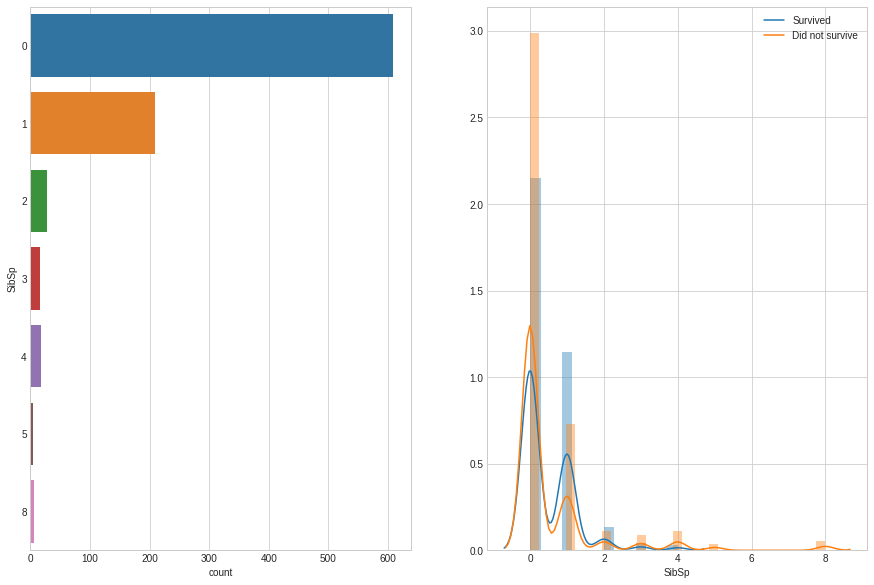

In [40]:
# Visualise the counts of SibSp and the distribution of the values
# against Survived
plot_count_dist(train, 
                bin_df=df_bin, 
                label_column='Survived', 
                target_column='SibSp', 
                figsize=(15, 10))

In [41]:
df_con.head()

,Survived,Pclass,Sex,SibSp,Parch
0,0,3,male,1,0
1,1,1,female,1,0
2,1,3,female,0,0
3,1,1,female,1,0
4,0,3,male,0,0


# Ticket 

In [42]:
missing_values['Ticket']

0

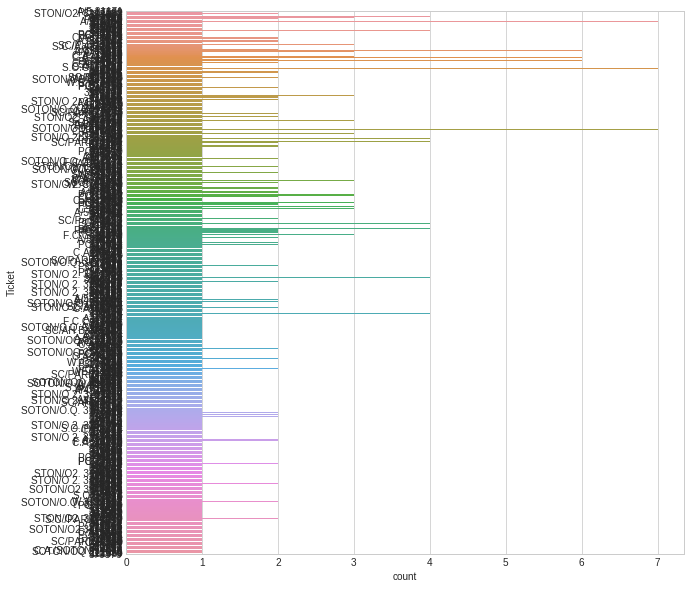

In [43]:
plt.figure(figsize = (10,10))
sns.countplot(y = 'Ticket', data = train)

In [44]:
train.Ticket.value_counts()

1601             7
347082           7
CA. 2343         7
CA 2144          6
3101295          6
347088           6
382652           5
S.O.C. 14879     5
LINE             4
113781           4
19950            4
W./C. 6608       4
2666             4
347077           4
PC 17757         4
349909           4
17421            4
4133             4
113760           4
C.A. 31921       3
PC 17572         3
239853           3
230080           3
110413           3
371110           3
110152           3
PC 17755         3
345773           3
29106            3
363291           3
                ..
392092           1
14312            1
220367           1
348121           1
29108            1
12460            1
19972            1
11765            1
349201           1
28551            1
349243           1
364850           1
330923           1
350036           1
3101296          1
248706           1
2700             1
364506           1
2677             1
13213            1
244373           1
65304       

In [45]:
print('there are {} different types of tickets'.format(len(train.Ticket.unique())))

there are 681 different types of tickets


# Fare 

In [46]:
missing_values['Fare']

0

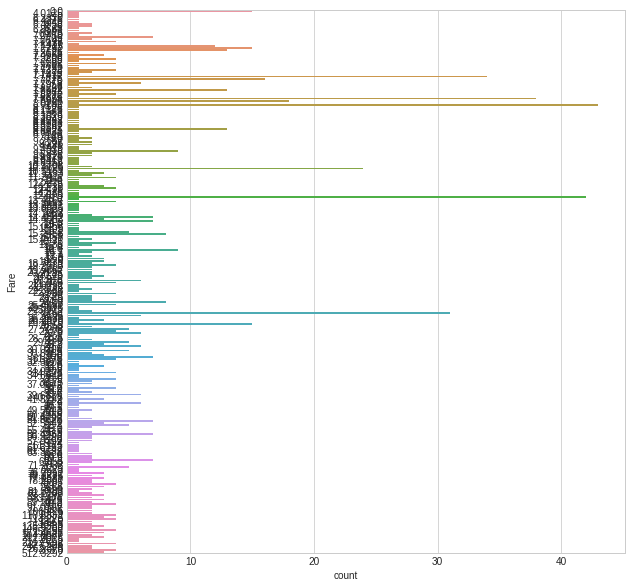

In [47]:
plt.figure(figsize = (10,10))
sns.countplot(y = 'Fare', data = train)

In [48]:
train.Fare.value_counts()

8.0500      43
13.0000     42
7.8958      38
7.7500      34
26.0000     31
10.5000     24
7.9250      18
7.7750      16
26.5500     15
0.0000      15
7.2292      15
7.8542      13
8.6625      13
7.2500      13
7.2250      12
16.1000      9
9.5000       9
24.1500      8
15.5000      8
56.4958      7
52.0000      7
14.5000      7
14.4542      7
69.5500      7
7.0500       7
31.2750      7
46.9000      6
30.0000      6
7.7958       6
39.6875      6
            ..
7.1417       1
42.4000      1
211.5000     1
12.2750      1
61.1750      1
8.4333       1
51.4792      1
7.8875       1
8.6833       1
7.5208       1
34.6542      1
28.7125      1
25.5875      1
7.7292       1
12.2875      1
8.6542       1
8.7125       1
61.3792      1
6.9500       1
9.8417       1
8.3000       1
13.7917      1
9.4750       1
13.4167      1
26.3875      1
8.4583       1
9.8375       1
8.3625       1
14.1083      1
17.4000      1
Name: Fare, Length: 248, dtype: int64

In [49]:
print('there are {} unique fare values'.format(len(train.Fare.unique())))

there are 248 unique fare values


In [50]:
train.Fare.dtype

dtype('float64')

In [51]:
#since it is a float value, we'll add it into our continuous dataframe, to add it into our discritised dataframe,
#we have to cut it into bins
df_con['Fare'] = train['Fare']
df_bin['Fare'] = pd.cut(train['Fare'], bins = 5)

In [52]:
df_bin.head()

,Survived,Pclass,Sex,SibSp,Parch,Fare
0,0,3,0,1,0,"(-0.512, 102.466]"
1,1,1,1,1,0,"(-0.512, 102.466]"
2,1,3,1,0,0,"(-0.512, 102.466]"
3,1,1,1,1,0,"(-0.512, 102.466]"
4,0,3,0,0,0,"(-0.512, 102.466]"


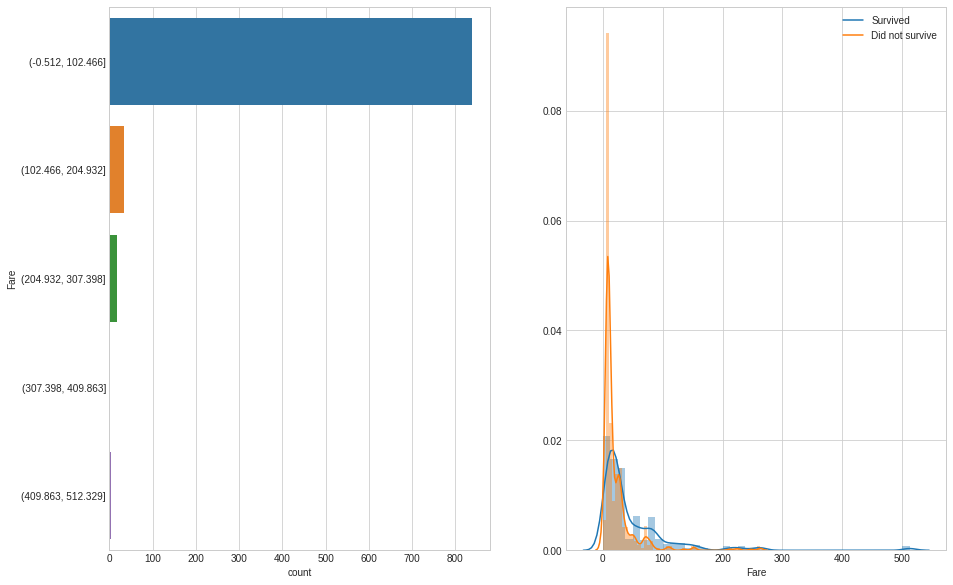

In [53]:
# Visualise the counts of SibSp and the distribution of the values
# against Survived
plot_count_dist(train, 
                bin_df=df_bin, 
                label_column='Survived', 
                target_column='Fare', 
                figsize=(15, 10),
                use_bin_df = True)

# **Cabins** 

In [54]:
missing_values['Cabin']

687

In [55]:
train.Cabin.value_counts()

B96 B98            4
C23 C25 C27        4
G6                 4
E101               3
F33                3
F2                 3
C22 C26            3
D                  3
C92                2
B35                2
B49                2
C68                2
C65                2
B57 B59 B63 B66    2
B22                2
B5                 2
C124               2
D26                2
B58 B60            2
D35                2
C83                2
C52                2
E33                2
D20                2
D17                2
E8                 2
B51 B53 B55        2
C78                2
D36                2
B18                2
                  ..
A7                 1
E46                1
B37                1
B80                1
C47                1
D30                1
E63                1
D48                1
D9                 1
B3                 1
B86                1
A23                1
C90                1
C111               1
F G63              1
B4                 1
C106         

# **Embarked**

In [56]:
missing_values['Embarked']

2

In [57]:
train.Embarked.value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [58]:
train.Embarked.value_counts().sum()

889

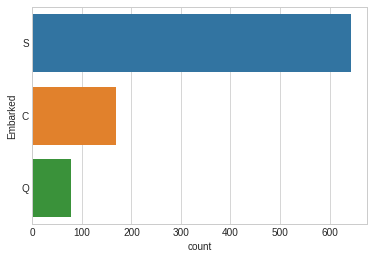

In [59]:
sns.countplot(y = 'Embarked', data = train)

In [60]:
df_bin['Embarked'] = train['Embarked']
df_con['Embarked'] = train['Embarked']

In [61]:
print(len(df_con))
df_con = df_con.dropna(subset=['Embarked'])
df_bin = df_bin.dropna(subset=['Embarked'])
print(len(df_con))

891
889


# **Feature Encoding**

In [62]:
df_bin.head()

,Survived,Pclass,Sex,SibSp,Parch,Fare,Embarked
0,0,3,0,1,0,"(-0.512, 102.466]",S
1,1,1,1,1,0,"(-0.512, 102.466]",C
2,1,3,1,0,0,"(-0.512, 102.466]",S
3,1,1,1,1,0,"(-0.512, 102.466]",S
4,0,3,0,0,0,"(-0.512, 102.466]",S


In [63]:
one_hot_cols = df_bin.columns.tolist()

In [64]:
one_hot_cols

['Survived', 'Pclass', 'Sex', 'SibSp', 'Parch', 'Fare', 'Embarked']

In [65]:
one_hot_cols.remove('Survived')

In [66]:
one_hot_cols

['Pclass', 'Sex', 'SibSp', 'Parch', 'Fare', 'Embarked']

In [67]:
df_bin_enc = pd.get_dummies(df_bin, columns = one_hot_cols)

In [68]:
df_bin_enc.head()

,Survived,Pclass_1,Pclass_2,Pclass_3,Sex_0,Sex_1,SibSp_0,SibSp_1,SibSp_2,SibSp_3,...,Parch_5,Parch_6,"Fare_(-0.512, 102.466]","Fare_(102.466, 204.932]","Fare_(204.932, 307.398]","Fare_(307.398, 409.863]","Fare_(409.863, 512.329]",Embarked_C,Embarked_Q,Embarked_S
0,0,0,0,1,1,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,1
1,1,1,0,0,0,1,0,1,0,0,...,0,0,1,0,0,0,0,1,0,0
2,1,0,0,1,0,1,1,0,0,0,...,0,0,1,0,0,0,0,0,0,1
3,1,1,0,0,0,1,0,1,0,0,...,0,0,1,0,0,0,0,0,0,1
4,0,0,0,1,1,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,1


In [69]:
df_con.head()

,Survived,Pclass,Sex,SibSp,Parch,Fare,Embarked
0,0,3,male,1,0,7.2500,S
1,1,1,female,1,0,71.2833,C
2,1,3,female,0,0,7.9250,S
3,1,1,female,1,0,53.1000,S
4,0,3,male,0,0,8.0500,S


In [70]:
#label encoding it
df_con_enc = df_con.apply(LabelEncoder().fit_transform)

In [71]:
df_con_enc.head()

,Survived,Pclass,Sex,SibSp,Parch,Fare,Embarked
0,0,2,1,1,0,18,2
1,1,0,0,1,0,207,0
2,1,2,0,0,0,41,2
3,1,0,0,1,0,189,2
4,0,2,1,0,0,43,2


# Start building some machine learning models 

In [72]:
# Seclect the dataframe we want to use first for predictions
selected_df = df_con_enc

In [73]:
x_train = selected_df.drop('Survived', axis = 1)

In [74]:
y_train = selected_df.Survived

In [75]:
x_train.head()

,Pclass,Sex,SibSp,Parch,Fare,Embarked
0,2,1,1,0,18,2
1,0,0,1,0,207,0
2,2,0,0,0,41,2
3,0,0,1,0,189,2
4,2,1,0,0,43,2


In [76]:
y_train.head()

0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

**Let's create a function to fit out data as we've to run our data through different machine learning algorithms**

In [77]:
def fit_algo(algo, x_train, y_train, cv):
    
    model = algo.fit(x_train, y_train)
    acc = round(model.score(x_train, y_train)*100, 4)
    
    train_pred = model_selection.cross_val_predict(algo, x_train, y_train, cv = cv, n_jobs = -1)
    
    acc_cv = round(metrics.accuracy_score(y_train, train_pred)*100, 4)
    
    return train_pred, acc, acc_cv

## Logistic regression 

In [79]:
start_time = time.time()
train_pred_log, acc_log, acc_cv_log = fit_algo(LogisticRegression(), x_train, y_train, 10)
log_time = (time.time() - start_time)
print('Accuracy: %s' % acc_log)
print('Accuracy CV 10-folds: %s' % acc_cv_log)
print(train_pred_log)
print('Running time: %s' % datetime.timedelta(seconds = log_time))

Accuracy: 79.0776
Accuracy CV 10-folds: 78.5152
[0 1 1 1 0 0 0 0 1 1 1 1 0 0 1 1 0 0 1 1 0 0 1 0 0 0 0 0 1 0 0 1 1 0 1 0 0
 0 1 1 1 1 0 1 1 0 0 1 0 1 0 0 1 1 1 0 1 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 1 1 1 0 1 0 0 0 0 0 1 0 0 1 0 1
 0 1 1 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 1 1 0 0 1 0 0 1 1 1 1 0 0 0 0 1 0
 0 0 1 0 0 0 1 1 0 0 0 0 1 0 0 0 0 1 1 0 0 0 0 1 0 1 0 0 1 0 0 0 0 0 0 1 0
 1 0 0 0 1 0 0 0 1 1 0 0 1 1 0 0 0 0 0 1 0 0 1 1 0 1 0 0 0 1 1 0 1 0 0 0 0
 0 0 0 0 0 0 0 1 0 0 0 0 1 0 1 0 0 1 1 0 0 0 0 1 1 0 0 0 1 0 0 1 1 1 1 1 1
 0 0 0 0 1 0 0 0 1 1 0 0 1 0 1 1 1 0 0 1 0 0 0 0 0 0 0 0 0 1 1 1 0 1 0 0 0
 1 0 1 1 0 0 1 0 0 1 1 0 1 1 1 1 0 0 1 1 0 1 1 0 0 1 1 0 1 0 1 1 1 1 0 1 0
 1 0 0 1 0 0 0 1 0 0 0 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 0 0 1 0 0 0 1 1 1 1 0
 0 0 1 0 1 1 1 0 0 1 1 0 1 0 0 0 1 0 1 0 0 0 1 1 0 1 0 0 1 0 0 1 0 1 0 0 0
 0 0 0 0 1 0 0 1 1 1 0 1 0 0 0 1 0 0 1 1 0 0 0 1 1 0 0 1 1 1 0 0 1 0 0 1 0
 0 1 0 1 0 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0

## K- Nearest Neighbors 

In [80]:
start_time = time.time()
train_pred_log, acc_log, acc_cv_log = fit_algo(KNeighborsClassifier(), x_train, y_train, 10)
log_time = (time.time() - start_time)
print('Accuracy: %s' % acc_log)
print('Accuracy CV 10-folds: %s' % acc_cv_log)
print(train_pred_log)
print('Running time: %s' % datetime.timedelta(seconds = log_time))

Accuracy: 81.4398
Accuracy CV 10-folds: 73.6783
[0 0 0 1 0 0 0 0 1 1 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 1 1 0 0 1 1 0 1 1 0
 0 1 1 0 0 0 0 1 0 0 1 0 1 0 0 1 1 1 0 1 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1
 0 0 0 0 1 0 0 0 0 1 1 0 0 1 0 0 0 1 1 0 0 1 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 1 0 0 0 1 1 1 1 0 0 1 0 0 0 0 1 0 0 1 1 0 1 1 1 1 0 0 1 0 0 1
 0 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 1 0 1 0 0 0 0 0 0 0 0 1 1 0
 0 0 0 0 1 0 0 0 0 1 0 0 1 1 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 1 0 1 1 0 0 0 0
 0 1 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 1 0 0 1 1 0 1 0 1 1 1 1
 0 0 1 0 1 0 0 0 1 1 1 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0
 1 1 1 1 0 0 1 0 1 1 0 0 1 1 1 1 0 1 0 1 0 1 1 0 0 1 1 0 1 0 1 1 1 1 0 1 0
 1 0 1 1 0 1 0 1 0 0 0 1 1 0 1 0 0 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1
 0 0 1 0 1 0 1 0 0 1 0 0 1 0 0 0 1 0 0 1 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 0
 0 0 0 0 1 0 0 0 0 1 0 0 0 1 0 0 0 0 1 0 0 0 0 0 1 0 1 1 0 0 1 0 0 0 0 1 0
 1 0 0 1 1 1 1 0 1 0 0 0 1 1 0 0 0 1 0 0 0 0 0 0 1 0

## Gaussian Naive bayes 

In [81]:
start_time = time.time()
train_pred_log, acc_log, acc_cv_log = fit_algo(GaussianNB(), x_train, y_train, 10)
log_time = (time.time() - start_time)
print('Accuracy: %s' % acc_log)
print('Accuracy CV 10-folds: %s' % acc_cv_log)
print(train_pred_log)
print('Running time: %s' % datetime.timedelta(seconds = log_time))

Accuracy: 76.7154
Accuracy CV 10-folds: 76.378
[0 1 1 1 0 0 1 0 1 1 1 1 0 0 1 1 0 0 1 1 0 0 1 1 0 0 0 0 1 0 1 1 1 0 1 1 0
 0 0 1 1 1 0 1 1 0 0 1 0 1 0 0 1 1 1 1 1 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 1 1 1 0 0 0 1 0 0 0 1 0 0 0 1 1 1 0 1 0 1 0 0 0 1 0 0 1 1 1
 0 1 1 0 0 0 1 0 0 0 1 1 1 0 0 0 1 0 0 0 1 1 0 0 1 1 0 1 1 1 1 0 0 0 0 1 0
 0 0 1 0 0 0 1 1 0 0 0 0 1 0 0 0 0 1 1 0 0 1 0 1 0 1 0 0 1 0 0 0 0 0 0 1 1
 1 0 0 0 1 0 1 0 1 1 0 0 1 1 0 0 0 0 0 1 0 0 1 1 0 1 0 0 0 1 1 0 1 0 0 0 0
 0 1 0 0 0 0 0 1 0 0 0 0 1 0 1 0 0 1 1 0 0 0 0 1 1 1 0 0 1 1 0 1 1 1 1 1 1
 0 0 1 0 1 0 0 0 1 1 1 0 1 1 1 1 1 0 0 1 0 0 0 0 1 0 0 0 0 1 1 1 0 1 0 1 0
 1 1 1 1 0 0 1 0 1 1 1 1 1 1 1 1 0 0 1 1 0 1 1 0 0 1 1 0 1 0 1 1 1 1 1 1 0
 1 0 1 1 0 1 0 1 0 0 0 1 1 1 0 0 0 1 0 0 0 0 1 1 1 1 0 1 1 0 0 0 1 1 1 1 1
 0 0 1 0 1 1 1 0 0 1 1 0 1 0 0 0 1 0 1 1 0 0 1 1 0 1 0 0 1 0 0 1 0 1 0 0 0
 0 0 0 0 1 0 0 1 1 1 0 1 0 0 0 1 0 0 1 1 0 0 0 1 1 0 1 1 1 1 1 0 1 0 0 1 0
 1 1 0 1 1 0 0 1 1 0 0 0 1 1 0 0 0 1 0 0 0 0 0 0 1 0 

## Linear Support Vector Machine 

In [82]:
start_time = time.time()
train_pred_log, acc_log, acc_cv_log = fit_algo(LinearSVC(), x_train, y_train, 10)
log_time = (time.time() - start_time)
print('Accuracy: %s' % acc_log)
print('Accuracy CV 10-folds: %s' % acc_cv_log)
print(train_pred_log)
print('Running time: %s' % datetime.timedelta(seconds = log_time))

Accuracy: 59.73
Accuracy CV 10-folds: 69.8538
[0 1 1 0 0 0 0 0 0 1 0 1 0 0 1 1 0 0 0 1 0 0 1 0 0 0 0 0 1 0 0 1 1 0 0 0 0
 0 0 1 1 0 0 0 1 0 0 1 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 1 0 1 1 0 0 1 1 1 0 0 1
 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 1 1 1 1 0 1 0 0 0 1 1 1 1 0 0 0 0
 0 1 0 0 0 0 1 1 0 0 1 0 1 1 1 0 0 1 1 0 0 0 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1
 0 1 1 0 1 0 0 0 1 1 1 0 1 1 1 1 1 0 0 1 0 0 0 0 1 0 0 0 0 1 1 1 0 1 0 1 0
 1 1 1 1 0 0 1 0 1 1 1 1 1 1 1 1 0 0 1 1 0 1 1 0 0 1 1 0 1 0 1 1 1 1 1 1 0
 1 0 1 1 0 1 0 1 0 0 0 1 1 1 0 0 0 1 0 0 0 0 0 1 1 1 0 0 1 0 0 0 1 1 1 1 0
 0 0 0 0 1 1 0 0 0 1 1 0 1 0 0 0 1 0 1 0 0 0 1 0 0 1 0 0 1 0 0 1 0 1 0 0 0
 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0

## Stochastic Gradient Descent 

In [83]:
start_time = time.time()
train_pred_log, acc_log, acc_cv_log = fit_algo(SGDClassifier(), x_train, y_train, 10)
log_time = (time.time() - start_time)
print('Accuracy: %s' % acc_log)
print('Accuracy CV 10-folds: %s' % acc_cv_log)
print(train_pred_log)
print('Running time: %s' % datetime.timedelta(seconds = log_time))

Accuracy: 44.5444
Accuracy CV 10-folds: 58.2677
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 0 1 1 0 0 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1
 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 0 1 1 1 1 1 1
 1 1 1 0 1 1 1 1 1 1 0 0 1 1 0 1 0 0 0 1 1 1 0 1 0 1 0 1 0 1 0 1 1 1 0 1 0
 0 1 0 1 0 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 0 0 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1
 1 1 1 0 1 1 1 0 1 1 1 0 1 1 0 1 1 0 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

### Decision Tree Classifier

In [84]:
start_time = time.time()
train_pred_log, acc_log, acc_cv_log = fit_algo(DecisionTreeClassifier(), x_train, y_train, 10)
log_time = (time.time() - start_time)
print('Accuracy: %s' % acc_log)
print('Accuracy CV 10-folds: %s' % acc_cv_log)
print(train_pred_log)
print('Running time: %s' % datetime.timedelta(seconds = log_time))

Accuracy: 92.4634
Accuracy CV 10-folds: 79.865
[0 1 0 1 0 0 0 0 1 1 1 1 0 0 0 1 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0 1 1 0 1 0 0
 0 1 1 0 1 0 1 1 0 0 1 0 1 0 0 1 1 0 0 1 0 1 0 0 1 0 0 1 1 0 0 0 0 1 0 0 1
 0 0 0 0 1 0 0 1 0 1 1 0 0 1 0 0 0 1 1 0 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 1 1 0 0 0 1 0 0 1 0 0 0 1 0 1 0 0 1 0 0 0
 0 0 1 0 1 0 0 1 0 0 0 1 1 0 0 0 0 1 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0
 1 0 1 0 1 0 0 1 1 1 0 1 1 1 0 0 0 0 0 1 0 0 1 0 0 1 0 0 0 1 0 0 1 0 0 0 0
 0 0 0 0 0 0 0 1 0 0 0 0 1 0 1 0 0 0 1 0 0 0 1 0 1 1 0 0 0 0 0 1 0 1 1 1 1
 0 0 0 0 1 0 0 0 1 1 1 0 1 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 1 0 0 0
 0 1 1 1 0 0 1 0 0 1 1 0 1 1 1 1 0 0 0 1 1 0 1 0 0 1 0 0 1 0 1 1 1 1 0 0 0
 1 0 0 1 0 1 1 1 0 0 0 1 1 0 1 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 1 1 1 1 0
 0 0 1 0 1 1 0 0 0 1 0 0 1 0 0 0 1 0 1 1 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0 1
 0 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 1 0 1 1 0 0 1 0 1 0 1 1 0
 0 1 0 1 1 1 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0 0 0 0 1 0 

## Gradient Boost Tree

In [85]:
start_time = time.time()
train_pred_log, acc_log, acc_cv_log = fit_algo(GradientBoostingClassifier(), x_train, y_train, 10)
log_time = (time.time() - start_time)
print('Accuracy: %s' % acc_log)
print('Accuracy CV 10-folds: %s' % acc_cv_log)
print(train_pred_log)
print('Running time: %s' % datetime.timedelta(seconds = log_time))

Accuracy: 86.3892
Accuracy CV 10-folds: 81.1024
[0 1 0 1 0 0 0 0 1 1 1 1 0 0 1 1 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0 1 1 0 1 0 0
 0 1 1 0 1 0 1 1 0 0 1 0 1 0 0 1 1 0 0 1 0 1 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1
 0 0 0 0 1 0 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0
 0 0 1 0 1 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 1 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0
 1 0 0 0 1 0 0 0 1 1 0 0 1 1 0 0 0 0 0 1 0 0 1 0 0 1 0 0 0 1 1 0 1 0 0 0 0
 0 0 0 0 0 0 0 1 0 0 0 0 1 0 1 0 0 0 1 0 0 0 0 1 1 0 0 0 1 0 0 1 1 1 1 1 1
 0 0 0 0 1 0 0 0 1 1 0 0 1 1 1 1 1 0 0 1 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0
 1 1 1 1 0 0 1 0 0 1 1 0 1 1 1 1 0 0 1 1 0 1 1 0 0 1 1 0 1 0 1 1 1 0 0 0 0
 1 0 0 1 0 1 0 1 0 0 0 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1
 0 0 1 0 1 1 0 0 0 1 1 0 1 0 0 0 1 0 1 1 0 0 1 1 0 1 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0 0 0 1 1 0 0 0 1 1 0 1 1 0 1 0 0 1 0 0 1 0
 0 1 0 1 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0

## Catboost

In [86]:
x_train.head()

,Pclass,Sex,SibSp,Parch,Fare,Embarked
0,2,1,1,0,18,2
1,0,0,1,0,207,0
2,2,0,0,0,41,2
3,0,0,1,0,189,2
4,2,1,0,0,43,2


In [87]:
y_train.head()

0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

In [88]:
cat_feature = np.where(x_train.dtypes != np.float)[0]
cat_feature

array([0, 1, 2, 3, 4, 5])

In [89]:
train_pool = Pool(x_train, y_train, cat_feature)

In [90]:
y_train.head()

0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

In [91]:
#  CatBoost model definition
catboost_model = CatBoostClassifier(iterations=1000,
                                    custom_loss=['Accuracy'],
                                    loss_function='Logloss')

# Fit CatBoost model
catboost_model.fit(train_pool,
                   plot=True)

# CatBoost accuracy
acc_catboost = round(catboost_model.score(x_train, y_train) * 100, 2)

Learning rate set to 0.016206


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6838699	total: 65.2ms	remaining: 1m 5s
1:	learn: 0.6753070	total: 74.9ms	remaining: 37.4s
2:	learn: 0.6664907	total: 87.8ms	remaining: 29.2s


3:	learn: 0.6580711	total: 102ms	remaining: 25.4s
4:	learn: 0.6509880	total: 113ms	remaining: 22.6s
5:	learn: 0.6430105	total: 122ms	remaining: 20.2s
6:	learn: 0.6363867	total: 130ms	remaining: 18.4s
7:	learn: 0.6298197	total: 136ms	remaining: 16.9s
8:	learn: 0.6229042	total: 148ms	remaining: 16.3s
9:	learn: 0.6164721	total: 155ms	remaining: 15.4s
10:	learn: 0.6090541	total: 168ms	remaining: 15.1s
11:	learn: 0.6031504	total: 179ms	remaining: 14.7s
12:	learn: 0.5977758	total: 186ms	remaining: 14.1s
13:	learn: 0.5920107	total: 197ms	remaining: 13.9s
14:	learn: 0.5865860	total: 207ms	remaining: 13.6s
15:	learn: 0.5815069	total: 216ms	remaining: 13.3s
16:	learn: 0.5766008	total: 223ms	remaining: 12.9s
17:	learn: 0.5734912	total: 229ms	remaining: 12.5s
18:	learn: 0.5683202	total: 237ms	remaining: 12.2s
19:	learn: 0.5638584	total: 249ms	remaining: 12.2s
20:	learn: 0.5592792	total: 256ms	remaining: 11.9s
21:	learn: 0.5544849	total: 268ms	remaining: 11.9s
22:	learn: 0.5505635	total: 285ms	rema

167:	learn: 0.4210753	total: 1.69s	remaining: 8.38s
168:	learn: 0.4209684	total: 1.7s	remaining: 8.35s
169:	learn: 0.4208641	total: 1.7s	remaining: 8.32s
170:	learn: 0.4205448	total: 1.71s	remaining: 8.3s
171:	learn: 0.4204534	total: 1.72s	remaining: 8.26s
172:	learn: 0.4203235	total: 1.72s	remaining: 8.23s
173:	learn: 0.4202465	total: 1.72s	remaining: 8.19s
174:	learn: 0.4198671	total: 1.74s	remaining: 8.19s
175:	learn: 0.4197881	total: 1.74s	remaining: 8.17s
176:	learn: 0.4197223	total: 1.75s	remaining: 8.14s
177:	learn: 0.4196545	total: 1.75s	remaining: 8.1s
178:	learn: 0.4195773	total: 1.76s	remaining: 8.07s
179:	learn: 0.4192400	total: 1.77s	remaining: 8.06s
180:	learn: 0.4190503	total: 1.77s	remaining: 8.03s
181:	learn: 0.4187767	total: 1.79s	remaining: 8.06s
182:	learn: 0.4185464	total: 1.81s	remaining: 8.06s
183:	learn: 0.4182871	total: 1.82s	remaining: 8.08s
184:	learn: 0.4180668	total: 1.85s	remaining: 8.14s
185:	learn: 0.4180429	total: 1.85s	remaining: 8.12s
186:	learn: 0.41

338:	learn: 0.4002484	total: 3.12s	remaining: 6.08s
339:	learn: 0.4002476	total: 3.12s	remaining: 6.06s
340:	learn: 0.4002395	total: 3.13s	remaining: 6.05s
341:	learn: 0.4001220	total: 3.14s	remaining: 6.04s
342:	learn: 0.3998889	total: 3.15s	remaining: 6.03s
343:	learn: 0.3998591	total: 3.15s	remaining: 6.02s
344:	learn: 0.3997578	total: 3.16s	remaining: 6s
345:	learn: 0.3997110	total: 3.17s	remaining: 5.99s
346:	learn: 0.3995905	total: 3.18s	remaining: 5.99s
347:	learn: 0.3995232	total: 3.19s	remaining: 5.97s
348:	learn: 0.3994344	total: 3.19s	remaining: 5.96s
349:	learn: 0.3994203	total: 3.2s	remaining: 5.94s
350:	learn: 0.3992071	total: 3.21s	remaining: 5.93s
351:	learn: 0.3991921	total: 3.21s	remaining: 5.91s
352:	learn: 0.3991184	total: 3.22s	remaining: 5.9s
353:	learn: 0.3989245	total: 3.23s	remaining: 5.89s
354:	learn: 0.3988903	total: 3.23s	remaining: 5.87s
355:	learn: 0.3987124	total: 3.24s	remaining: 5.87s
356:	learn: 0.3987124	total: 3.25s	remaining: 5.85s
357:	learn: 0.398

499:	learn: 0.3863897	total: 4.6s	remaining: 4.6s
500:	learn: 0.3863703	total: 4.61s	remaining: 4.59s
501:	learn: 0.3860569	total: 4.62s	remaining: 4.58s
502:	learn: 0.3859608	total: 4.63s	remaining: 4.58s
503:	learn: 0.3859430	total: 4.64s	remaining: 4.56s
504:	learn: 0.3857445	total: 4.64s	remaining: 4.55s
505:	learn: 0.3856026	total: 4.65s	remaining: 4.54s
506:	learn: 0.3855871	total: 4.66s	remaining: 4.53s
507:	learn: 0.3852677	total: 4.67s	remaining: 4.52s
508:	learn: 0.3850973	total: 4.67s	remaining: 4.51s
509:	learn: 0.3849203	total: 4.68s	remaining: 4.5s
510:	learn: 0.3848381	total: 4.69s	remaining: 4.49s
511:	learn: 0.3848316	total: 4.7s	remaining: 4.48s
512:	learn: 0.3846123	total: 4.71s	remaining: 4.47s
513:	learn: 0.3842572	total: 4.72s	remaining: 4.46s
514:	learn: 0.3842197	total: 4.73s	remaining: 4.46s
515:	learn: 0.3840301	total: 4.74s	remaining: 4.45s
516:	learn: 0.3839063	total: 4.75s	remaining: 4.44s
517:	learn: 0.3838866	total: 4.75s	remaining: 4.42s
518:	learn: 0.38

665:	learn: 0.3641918	total: 6.33s	remaining: 3.17s
666:	learn: 0.3641678	total: 6.34s	remaining: 3.17s
667:	learn: 0.3637879	total: 6.35s	remaining: 3.16s
668:	learn: 0.3635429	total: 6.37s	remaining: 3.15s
669:	learn: 0.3632952	total: 6.39s	remaining: 3.15s
670:	learn: 0.3632389	total: 6.4s	remaining: 3.14s
671:	learn: 0.3631914	total: 6.42s	remaining: 3.13s
672:	learn: 0.3631689	total: 6.43s	remaining: 3.12s
673:	learn: 0.3630412	total: 6.43s	remaining: 3.11s
674:	learn: 0.3629690	total: 6.45s	remaining: 3.1s
675:	learn: 0.3628310	total: 6.45s	remaining: 3.09s
676:	learn: 0.3628021	total: 6.46s	remaining: 3.08s
677:	learn: 0.3627001	total: 6.47s	remaining: 3.07s
678:	learn: 0.3626838	total: 6.48s	remaining: 3.06s
679:	learn: 0.3626079	total: 6.49s	remaining: 3.05s
680:	learn: 0.3625732	total: 6.5s	remaining: 3.04s
681:	learn: 0.3625545	total: 6.51s	remaining: 3.03s
682:	learn: 0.3624907	total: 6.51s	remaining: 3.02s
683:	learn: 0.3623967	total: 6.53s	remaining: 3.01s
684:	learn: 0.3

826:	learn: 0.3461356	total: 8.06s	remaining: 1.69s
827:	learn: 0.3458489	total: 8.07s	remaining: 1.68s
828:	learn: 0.3458394	total: 8.08s	remaining: 1.67s
829:	learn: 0.3457873	total: 8.09s	remaining: 1.66s
830:	learn: 0.3457646	total: 8.1s	remaining: 1.65s
831:	learn: 0.3457118	total: 8.11s	remaining: 1.64s
832:	learn: 0.3456755	total: 8.11s	remaining: 1.63s
833:	learn: 0.3455890	total: 8.12s	remaining: 1.62s
834:	learn: 0.3455098	total: 8.13s	remaining: 1.61s
835:	learn: 0.3454441	total: 8.14s	remaining: 1.6s
836:	learn: 0.3451719	total: 8.15s	remaining: 1.59s
837:	learn: 0.3451493	total: 8.16s	remaining: 1.58s
838:	learn: 0.3450840	total: 8.17s	remaining: 1.57s
839:	learn: 0.3449077	total: 8.18s	remaining: 1.56s
840:	learn: 0.3448994	total: 8.19s	remaining: 1.55s
841:	learn: 0.3447676	total: 8.2s	remaining: 1.54s
842:	learn: 0.3446240	total: 8.21s	remaining: 1.53s
843:	learn: 0.3446038	total: 8.22s	remaining: 1.52s
844:	learn: 0.3445047	total: 8.22s	remaining: 1.51s
845:	learn: 0.3

994:	learn: 0.3300252	total: 9.78s	remaining: 49.1ms
995:	learn: 0.3299024	total: 9.79s	remaining: 39.3ms
996:	learn: 0.3298607	total: 9.8s	remaining: 29.5ms
997:	learn: 0.3298303	total: 9.81s	remaining: 19.7ms
998:	learn: 0.3297707	total: 9.84s	remaining: 9.85ms
999:	learn: 0.3296627	total: 9.85s	remaining: 0us


In [93]:


# Perform CatBoost cross-validation
start_time = time.time()

# Set params for cross-validation as same as initial model
cv_params = catboost_model.get_params()

# Run the cross-validation for 10-folds (same as the other models)
cv_data = cv(train_pool,
             cv_params,
             fold_count=10,
             plot=True)

# How long did it take?
catboost_time = (time.time() - start_time)

# CatBoost CV results save into a dataframe (cv_data), let's withdraw the maximum accuracy score
acc_cv_catboost = round(np.max(cv_data['test-Accuracy-mean']) * 100, 2)



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6841256	test: 0.6840888	best: 0.6840888 (0)
1:	learn: 0.6755854	test: 0.6759349	best: 0.6759349 (1)
2:	learn: 0.6673580	test: 0.6678242	best: 0.6678242 (2)
3:	learn: 0.6593220	test: 0.6598724	best: 0.6598724 (3)
4:	learn: 0.6516587	test: 0.6521665	best: 0.6521665 (4)
5:	learn: 0.6443556	test: 0.6451184	best: 0.6451184 (5)
6:	learn: 0.6376641	test: 0.6384372	best: 0.6384372 (6)
7:	learn: 0.6312767	test: 0.6317963	best: 0.6317963 (7)
8:	learn: 0.6247155	test: 0.6253194	best: 0.6253194 (8)
9:	learn: 0.6185368	test: 0.6193121	best: 0.6193121 (9)
10:	learn: 0.6125186	test: 0.6132487	best: 0.6132487 (10)
11:	learn: 0.6068958	test: 0.6078234	best: 0.6078234 (11)
12:	learn: 0.6016277	test: 0.6027394	best: 0.6027394 (12)
13:	learn: 0.5960680	test: 0.5972147	best: 0.5972147 (13)
14:	learn: 0.5909693	test: 0.5920910	best: 0.5920910 (14)
15:	learn: 0.5857014	test: 0.5870332	best: 0.5870332 (15)
16:	learn: 0.5808991	test: 0.5822727	best: 0.5822727 (16)
17:	learn: 0.5762708	test: 0.57779

174:	learn: 0.4149723	test: 0.4411447	best: 0.4411447 (174)
175:	learn: 0.4148116	test: 0.4410810	best: 0.4410810 (175)
176:	learn: 0.4146889	test: 0.4409979	best: 0.4409979 (176)
177:	learn: 0.4145034	test: 0.4409990	best: 0.4409979 (176)
178:	learn: 0.4143293	test: 0.4409382	best: 0.4409382 (178)
179:	learn: 0.4141462	test: 0.4408856	best: 0.4408856 (179)
180:	learn: 0.4139008	test: 0.4408187	best: 0.4408187 (180)
181:	learn: 0.4137148	test: 0.4406551	best: 0.4406551 (181)
182:	learn: 0.4135757	test: 0.4406590	best: 0.4406551 (181)
183:	learn: 0.4133705	test: 0.4405384	best: 0.4405384 (183)
184:	learn: 0.4131273	test: 0.4404583	best: 0.4404583 (184)
185:	learn: 0.4129607	test: 0.4402724	best: 0.4402724 (185)
186:	learn: 0.4127454	test: 0.4402369	best: 0.4402369 (186)
187:	learn: 0.4125621	test: 0.4400576	best: 0.4400576 (187)
188:	learn: 0.4123461	test: 0.4399141	best: 0.4399141 (188)
189:	learn: 0.4121610	test: 0.4397417	best: 0.4397417 (189)
190:	learn: 0.4119615	test: 0.4395699	be

732:	learn: 0.3533686	test: 0.4313542	best: 0.4303689 (531)
733:	learn: 0.3532436	test: 0.4313340	best: 0.4303689 (531)
734:	learn: 0.3531847	test: 0.4313581	best: 0.4303689 (531)
735:	learn: 0.3530921	test: 0.4313388	best: 0.4303689 (531)
736:	learn: 0.3529860	test: 0.4313035	best: 0.4303689 (531)
737:	learn: 0.3528878	test: 0.4313092	best: 0.4303689 (531)
738:	learn: 0.3527829	test: 0.4312889	best: 0.4303689 (531)
739:	learn: 0.3526697	test: 0.4312828	best: 0.4303689 (531)
740:	learn: 0.3526054	test: 0.4312733	best: 0.4303689 (531)
741:	learn: 0.3525364	test: 0.4312951	best: 0.4303689 (531)
742:	learn: 0.3524471	test: 0.4312664	best: 0.4303689 (531)
743:	learn: 0.3523748	test: 0.4311790	best: 0.4303689 (531)
744:	learn: 0.3522475	test: 0.4311729	best: 0.4303689 (531)
745:	learn: 0.3521506	test: 0.4312038	best: 0.4303689 (531)
746:	learn: 0.3520909	test: 0.4311825	best: 0.4303689 (531)
747:	learn: 0.3519775	test: 0.4311722	best: 0.4303689 (531)
748:	learn: 0.3518316	test: 0.4313162	be

In [94]:
# Print out the CatBoost model metrics
print("---CatBoost Metrics---")
print("Accuracy: {}".format(acc_catboost))
print("Accuracy CV 10-Fold: {}".format(acc_cv_catboost))
print("Running Time: {}".format(datetime.timedelta(seconds=catboost_time)))


---CatBoost Metrics---
Accuracy: 87.63
Accuracy CV 10-Fold: 81.66
Running Time: 0:01:46.355373


# Final phase 

In [97]:
# We need our test dataframe to look like this one
x_train.head()

,Pclass,Sex,SibSp,Parch,Fare,Embarked
0,2,1,1,0,18,2
1,0,0,1,0,207,0
2,2,0,0,0,41,2
3,0,0,1,0,189,2
4,2,1,0,0,43,2


In [98]:
# Our test dataframe has some columns our model hasn't been trained on
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [100]:
wanted_test_columns = x_train.columns
wanted_test_columns

Index(['Pclass', 'Sex', 'SibSp', 'Parch', 'Fare', 'Embarked'], dtype='object')

In [101]:
# Make a prediction using the CatBoost model on the wanted columns
predictions = catboost_model.predict(test[wanted_test_columns]
                                     .apply(LabelEncoder().fit_transform))

In [102]:
predictions[:20]

array([0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 1., 1., 0.,
       0., 1., 1.])

In [103]:
# Create a submisison dataframe and append the relevant columns
submission = pd.DataFrame()
submission['PassengerId'] = test['PassengerId']
submission['Survived'] = predictions # our model predictions on the test dataset
submission.head()

,PassengerId,Survived
0,892,0.0
1,893,0.0
2,894,0.0
3,895,0.0
4,896,0.0


In [104]:
# Let's convert our submission dataframe 'Survived' column to ints
submission['Survived'] = submission['Survived'].astype(int)
print('Converted Survived column to integers.')

Converted Survived column to integers.


In [105]:
submission.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


In [106]:
submission.to_csv('../catboost_submission.csv', index=False)

In [107]:
submissions_check = pd.read_csv("../catboost_submission.csv")
submissions_check.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


# THE-END 